# Tutorial on Online Non-Negative Matrix Factorization

This notebooks explains basic ideas behind NMF implementation, training examples and use-cases.

**Matrix Factorizations** are useful for many things: recomendation systems, bi-clustering, image compression and, in particular, topic modeling.

Why **Non-Negative**? It makes the problem more strict and allows us to apply some optimizations.

Why **Online**? Because corpora are large and RAM is limited. Online NMF can learn topics iteratively.

This particular implementation is based on [this paper](arxiv.org/abs/1604.02634).

## Training

In [3]:
%load_ext line_profiler
%load_ext autoreload

%autoreload 2

import time

import logging
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition.nmf import NMF as SklearnNmf
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

from gensim import matutils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel
from gensim.models.nmf import Nmf as GensimNmf
from gensim.parsing.preprocessing import preprocess_string

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Dataset preprocessing

In [4]:
categories = [
    'alt.atheism',
    'comp.graphics',
    'rec.motorcycles',
    'talk.politics.mideast',
    'sci.space'
]

trainset = fetch_20newsgroups(subset='train', categories=categories, random_state=42)
testset = fetch_20newsgroups(subset='test', categories=categories, random_state=42)

train_documents = [preprocess_string(doc) for doc in trainset.data]
test_documents = [preprocess_string(doc) for doc in testset.data]

### Dictionary compilation

In [5]:
dictionary = Dictionary(train_documents)
dictionary.filter_extremes()

2019-01-10 14:00:40,291 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-01-10 14:00:40,933 : INFO : built Dictionary(25279 unique tokens: ['angu', 'bb', 'carri', 'demonstr', 'dragon']...) from 2819 documents (total 435328 corpus positions)
2019-01-10 14:00:40,983 : INFO : discarding 18198 tokens: [('angu', 2), ('edu', 1785), ('line', 2748), ('lussmyer', 1), ('organ', 2602), ('subject', 2819), ('write', 1743), ('absood', 4), ('deragatori', 3), ('indistinct', 3)]...
2019-01-10 14:00:40,984 : INFO : keeping 7081 tokens which were in no less than 5 and no more than 1409 (=50.0%) documents
2019-01-10 14:00:41,000 : INFO : resulting dictionary: Dictionary(7081 unique tokens: ['bb', 'carri', 'demonstr', 'dragon', 'exactli']...)


### Corpora compilation

In [6]:
train_corpus = [
    dictionary.doc2bow(document)
    for document
    in train_documents
]

test_corpus = [
    dictionary.doc2bow(document)
    for document
    in test_documents
]

### Training

The API works in the way similar to [Gensim.models.LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html).

Specific parameters:

- `use_r` - whether to use residuals. Effectively adds regularization to the model
- `kappa` - optimizer step size coefficient.
- `lambda_` - residuals coefficient. The larger it is, the less more regularized result gets.
- `sparse_coef` - internal matrices sparse coefficient. The more it is, the faster and less accurate training is.

In [8]:
%%time

nmf = GensimNmf(
    corpus=train_corpus,
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
    use_r=False,
    lambda_=1000,
    kappa=1,
    sparse_coef=3
)

2019-01-10 14:01:06,440 : INFO : Loss (no outliers): 605.9590769629461	Loss (with outliers): 605.9590769629461
2019-01-10 14:01:06,829 : INFO : Loss (no outliers): 572.0459011956622	Loss (with outliers): 572.0459011956622


CPU times: user 1.44 s, sys: 0 ns, total: 1.44 s
Wall time: 1.43 s


### Topics

In [9]:
nmf.show_topics()

[(0,
  '0.035*"god" + 0.030*"atheist" + 0.021*"believ" + 0.020*"exist" + 0.019*"atheism" + 0.016*"religion" + 0.013*"christian" + 0.013*"religi" + 0.013*"peopl" + 0.012*"argument"'),
 (1,
  '0.055*"imag" + 0.054*"jpeg" + 0.033*"file" + 0.024*"gif" + 0.021*"color" + 0.019*"format" + 0.015*"program" + 0.014*"version" + 0.013*"bit" + 0.012*"us"'),
 (2,
  '0.053*"space" + 0.034*"launch" + 0.024*"satellit" + 0.017*"nasa" + 0.016*"orbit" + 0.013*"year" + 0.012*"mission" + 0.011*"data" + 0.010*"commerci" + 0.010*"market"'),
 (3,
  '0.022*"armenian" + 0.021*"peopl" + 0.020*"said" + 0.018*"know" + 0.011*"sai" + 0.011*"went" + 0.010*"come" + 0.010*"like" + 0.010*"apart" + 0.009*"azerbaijani"'),
 (4,
  '0.024*"graphic" + 0.017*"pub" + 0.015*"mail" + 0.013*"data" + 0.013*"ftp" + 0.012*"send" + 0.011*"imag" + 0.011*"rai" + 0.010*"object" + 0.010*"com"')]

### Coherence

In [10]:
CoherenceModel(
    model=nmf,
    corpus=test_corpus,
    coherence='u_mass'
).get_coherence()

2019-01-10 14:01:20,890 : INFO : CorpusAccumulator accumulated stats from 1000 documents


-1.6698708891486376

### Perplexity

In [11]:
np.exp(-nmf.log_perplexity(test_corpus))

56.99992543062592

### Document topics inference

In [12]:
print(testset.data[0])
print("Topics: {}".format(nmf[test_corpus[0]]))

From: aa229@Freenet.carleton.ca (Steve Birnbaum)
Subject: Re: rejoinder. Questions to Israelis
Reply-To: aa229@Freenet.carleton.ca (Steve Birnbaum)
Organization: The National Capital Freenet
Lines: 27


In a previous article, ohayon@jcpltyo.JCPL.CO.JP (Tsiel Ohayon) says:

>I agree with all you write except that Terrorist orgs. were not shelling
>Israel from the Golan Heights in 1982, but rather from Lebanon. The Golan
>Heights have been held by Israel since 1967, and therefore the PLO could
>not have been shelling Israel from there, unless there is something I am
>not aware of.

Oops...small mistake.  Thanks for mentioning it.  I just read on
the.Israel.line that a village just got shelled by terrorists last week 
and some children were killed.  I guess the terrorists must have gotten by
the security zone.  Just think at how much more shelling would be 
happening if the security zone weren't there.
L8r...

   Steve
-- 
------------------------------------------------------------------

### Word topic inference

In [13]:
word = dictionary[11]
print("Word: {}".format(word))
print("Topics: {}".format(nmf.get_term_topics(word)))

Word: low
Topics: [(1, 0.27833206789570997), (2, 0.7216679321042901)]


### Internal state

In [14]:
def density(sparse_matrix):
    return sparse_matrix.nnz / np.multiply(*sparse_matrix.shape)

Term-topic matrix of shape `(words, topics)`.

In [15]:
nmf._W

<7081x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1839 stored elements in Compressed Sparse Column format>

In [16]:
print("Density: {}".format(density(nmf._W)))

Density: 0.05194181612766558


Topic-document matrix for the last batch of shape `(topics, batch)`

In [17]:
nmf._h

<5x819 sparse matrix of type '<class 'numpy.float64'>'
	with 3489 stored elements in Compressed Sparse Row format>

In [18]:
print("Density: {}".format(density(nmf._h)))

Density: 0.852014652014652


Residuals matrix of the last batch of shape `(words, batch)`

In [19]:
nmf._r

<7081x819 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [20]:
print("Density: {}".format(density(nmf._r)))

Density: 0.0


# Benchmarks

## Gensim NMF vs Sklearn NMF vs Gensim LDA

In [21]:
variable_params_grid = list(ParameterGrid(dict(
    use_r=[False, True],
    sparse_coef=[0, 3],
    lambda_=[1, 10, 100]
)))

fixed_params = dict(
    corpus=train_corpus,
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0,
    random_state=42,
)

In [22]:
def get_execution_time(func):
    start = time.time()

    result = func()

    return (time.time() - start), result


def get_tm_f1(model, train_corpus, X_test, y_train, y_test):
    X_train = np.zeros((len(train_corpus), model.num_topics))
    for bow_id, bow in enumerate(train_corpus):
        for topic_id, proba in model[bow]:
            X_train[bow_id, topic_id] = proba

    log_reg = LogisticRegressionCV(multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')


def get_sklearn_f1(model, train_corpus, X_test, y_train, y_test):
    X_train = model.transform((train_corpus / train_corpus.sum(axis=0)).T)

    log_reg = LogisticRegressionCV(multi_class='multinomial')
    log_reg.fit(X_train, y_train)

    pred_labels = log_reg.predict(X_test)

    return f1_score(y_test, pred_labels, average='micro')


def get_tm_metrics(model, train_corpus, test_corpus, dense_corpus, y_train, y_test):
    W = model.get_topics().T
    H = np.zeros((model.num_topics, len(test_corpus)))
    for bow_id, bow in enumerate(test_corpus):
        for topic_id, proba in model[bow]:
            H[topic_id, bow_id] = proba

    perplexity = get_tm_perplexity(W, H, dense_corpus)

    coherence = CoherenceModel(
        model=model,
        corpus=test_corpus,
        coherence='u_mass'
    ).get_coherence()

    l2_norm = get_tm_l2_norm(W, H, dense_corpus)

    f1 = get_tm_f1(model, train_corpus, H.T, y_train, y_test)

    topics = model.show_topics()

    return dict(
        perplexity=perplexity,
        coherence=coherence,
        topics=topics,
        l2_norm=l2_norm,
        f1=f1,
    )


def get_tm_perplexity(W, H, dense_corpus):
    pred_factors = W.dot(H)

    return np.exp(-(np.log(pred_factors, where=pred_factors > 0) * dense_corpus).sum() / dense_corpus.sum())


def get_tm_l2_norm(W, H, dense_corpus):
    return np.linalg.norm(dense_corpus / dense_corpus.sum(axis=0) - W.dot(H))


def get_sklearn_metrics(model, train_corpus, test_corpus, y_train, y_test):
    W = model.components_.T
    H = model.transform((test_corpus / test_corpus.sum(axis=0)).T).T
    pred_factors = W.dot(H)

    perplexity = np.exp(
        -(np.log(pred_factors, where=pred_factors > 0) * test_corpus).sum()
        / test_corpus.sum()
    )

    l2_norm = np.linalg.norm(test_corpus / test_corpus.sum(axis=0) - pred_factors)

    f1 = get_sklearn_f1(model, train_corpus, H.T, y_train, y_test)

    return dict(
        perplexity=perplexity,
        l2_norm=l2_norm,
        f1=f1,
    )

In [23]:
tm_metrics = pd.DataFrame()

train_dense_corpus = matutils.corpus2dense(train_corpus, len(dictionary))
test_dense_corpus = matutils.corpus2dense(test_corpus, len(dictionary))

# LDA metrics
row = dict()
row['model'] = 'lda'
row['train_time'], lda = get_execution_time(
    lambda: LdaModel(**fixed_params)
)
row.update(get_tm_metrics(
    lda, train_corpus, test_corpus, test_dense_corpus, trainset.target, testset.target,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

# Sklearn NMF metrics
row = dict()
row['model'] = 'sklearn_nmf'
sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)
row['train_time'], sklearn_nmf = get_execution_time(
    lambda: sklearn_nmf.fit((train_dense_corpus / train_dense_corpus.sum(axis=0)).T)
)
row.update(get_sklearn_metrics(
    sklearn_nmf, train_dense_corpus, test_dense_corpus, trainset.target, testset.target,
))
tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

for variable_params in variable_params_grid:
    row = dict()
    row['model'] = 'gensim_nmf'
    row.update(variable_params)
    row['train_time'], model = get_execution_time(
        lambda: GensimNmf(
            **fixed_params,
            **variable_params,
        )
    )
    row.update(get_tm_metrics(
        model, train_corpus, test_corpus, test_dense_corpus, trainset.target, testset.target,
    ))
    tm_metrics = tm_metrics.append(pd.Series(row), ignore_index=True)

2019-01-10 14:02:28,228 : INFO : using symmetric alpha at 0.2
2019-01-10 14:02:28,229 : INFO : using symmetric eta at 0.2
2019-01-10 14:02:28,231 : INFO : using serial LDA version on this node
2019-01-10 14:02:28,237 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 2819 documents, updating model once every 1000 documents, evaluating perplexity every 2819 documents, iterating 50x with a convergence threshold of 0.001000
2019-01-10 14:02:28,238 : INFO : PROGRESS: pass 0, at document #1000/2819
2019-01-10 14:02:29,464 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-01-10 14:02:29,471 : INFO : topic #0 (0.200): 0.006*"like" + 0.005*"com" + 0.004*"think" + 0.004*"know" + 0.004*"armenian" + 0.004*"peopl" + 0.004*"host" + 0.004*"new" + 0.003*"univers" + 0.003*"said"
2019-01-10 14:02:29,473 : INFO : topic #1 (0.200): 0.009*"com" + 0.006*"univers" + 0.005*"host" + 0.005*"nntp" + 0.005*"like" + 0.004*"time" + 0.004

2019-01-10 14:02:35,678 : INFO : topic diff=0.444120, rho=0.455535
2019-01-10 14:02:35,679 : INFO : PROGRESS: pass 2, at document #1000/2819
2019-01-10 14:02:36,369 : INFO : merging changes from 1000 documents into a model of 2819 documents
2019-01-10 14:02:36,375 : INFO : topic #0 (0.200): 0.009*"com" + 0.008*"imag" + 0.008*"like" + 0.006*"host" + 0.006*"nntp" + 0.005*"bike" + 0.005*"know" + 0.005*"univers" + 0.005*"bit" + 0.005*"version"
2019-01-10 14:02:36,377 : INFO : topic #1 (0.200): 0.012*"com" + 0.006*"host" + 0.006*"imag" + 0.006*"univers" + 0.006*"bike" + 0.006*"nntp" + 0.005*"file" + 0.005*"graphic" + 0.004*"dod" + 0.004*"like"
2019-01-10 14:02:36,378 : INFO : topic #2 (0.200): 0.019*"space" + 0.009*"nasa" + 0.007*"launch" + 0.007*"orbit" + 0.006*"year" + 0.005*"new" + 0.004*"com" + 0.004*"satellit" + 0.004*"moon" + 0.004*"mission"
2019-01-10 14:02:36,381 : INFO : topic #3 (0.200): 0.011*"armenian" + 0.009*"peopl" + 0.008*"israel" + 0.007*"isra" + 0.006*"turkish" + 0.006*"sa

2019-01-10 14:02:42,146 : INFO : topic #1 (0.200): 0.013*"com" + 0.007*"imag" + 0.006*"bike" + 0.006*"host" + 0.006*"univers" + 0.005*"nntp" + 0.005*"graphic" + 0.005*"file" + 0.005*"dod" + 0.004*"ride"
2019-01-10 14:02:42,148 : INFO : topic #2 (0.200): 0.020*"space" + 0.010*"nasa" + 0.008*"orbit" + 0.007*"launch" + 0.006*"year" + 0.005*"new" + 0.005*"satellit" + 0.004*"moon" + 0.004*"mission" + 0.004*"gov"
2019-01-10 14:02:42,149 : INFO : topic #3 (0.200): 0.012*"armenian" + 0.009*"peopl" + 0.008*"israel" + 0.007*"isra" + 0.006*"turkish" + 0.006*"said" + 0.005*"jew" + 0.005*"right" + 0.005*"kill" + 0.005*"know"
2019-01-10 14:02:42,150 : INFO : topic #4 (0.200): 0.013*"god" + 0.009*"peopl" + 0.008*"think" + 0.007*"believ" + 0.006*"moral" + 0.006*"islam" + 0.006*"atheist" + 0.006*"exist" + 0.006*"com" + 0.006*"thing"
2019-01-10 14:02:42,151 : INFO : topic diff=0.204190, rho=0.357622
2019-01-10 14:02:42,152 : INFO : PROGRESS: pass 4, at document #2000/2819
2019-01-10 14:02:42,715 : INFO 

In [24]:
tm_metrics.sort_values('f1')

,coherence,f1,l2_norm,model,perplexity,topics,train_time,lambda_,sparse_coef,use_r
5,-1.572423,0.548507,7.210668,gensim_nmf,21.189874,"[(0, 0.034*""peopl"" + 0.025*""wai"" + 0.020*""come...",7.934776,1.0,3.0,1.0
9,-1.794092,0.643923,7.247913,gensim_nmf,49.029435,"[(0, 0.034*""god"" + 0.023*""exist"" + 0.022*""beli...",9.610066,10.0,3.0,1.0
4,-1.669871,0.665245,7.168078,gensim_nmf,56.999925,"[(0, 0.035*""god"" + 0.030*""atheist"" + 0.021*""be...",1.890566,1.0,3.0,0.0
8,-1.669871,0.665245,7.168078,gensim_nmf,56.999925,"[(0, 0.035*""god"" + 0.030*""atheist"" + 0.021*""be...",1.819997,10.0,3.0,0.0
12,-1.669871,0.665245,7.168078,gensim_nmf,56.999925,"[(0, 0.035*""god"" + 0.030*""atheist"" + 0.021*""be...",1.803650,100.0,3.0,0.0
13,-1.667488,0.671109,7.167259,gensim_nmf,55.940074,"[(0, 0.035*""god"" + 0.030*""atheist"" + 0.021*""be...",13.839733,100.0,3.0,1.0
2,-1.651645,0.671642,7.060985,gensim_nmf,2534.426980,"[(0, 0.020*""god"" + 0.017*""atheist"" + 0.012*""be...",4.403016,1.0,0.0,0.0
6,-1.651645,0.671642,7.060985,gensim_nmf,2534.426980,"[(0, 0.020*""god"" + 0.017*""atheist"" + 0.012*""be...",4.795221,10.0,0.0,0.0
10,-1.651645,0.671642,7.060985,gensim_nmf,2534.426980,"[(0, 0.020*""god"" + 0.017*""atheist"" + 0.012*""be...",6.848814,100.0,0.0,0.0
11,-1.713672,0.676972,7.058523,gensim_nmf,2526.410173,"[(0, 0.020*""god"" + 0.017*""atheist"" + 0.012*""be...",56.289639,100.0,0.0,1.0


In [30]:
tm_metrics.iloc[12].topics

[(0,
  '0.035*"god" + 0.030*"atheist" + 0.021*"believ" + 0.020*"exist" + 0.019*"atheism" + 0.016*"religion" + 0.013*"christian" + 0.013*"religi" + 0.013*"peopl" + 0.012*"argument"'),
 (1,
  '0.055*"imag" + 0.054*"jpeg" + 0.033*"file" + 0.024*"gif" + 0.021*"color" + 0.019*"format" + 0.015*"program" + 0.014*"version" + 0.013*"bit" + 0.012*"us"'),
 (2,
  '0.053*"space" + 0.034*"launch" + 0.024*"satellit" + 0.017*"nasa" + 0.016*"orbit" + 0.013*"year" + 0.012*"mission" + 0.011*"data" + 0.010*"commerci" + 0.010*"market"'),
 (3,
  '0.022*"armenian" + 0.021*"peopl" + 0.020*"said" + 0.018*"know" + 0.011*"sai" + 0.011*"went" + 0.010*"come" + 0.010*"like" + 0.010*"apart" + 0.009*"azerbaijani"'),
 (4,
  '0.024*"graphic" + 0.017*"pub" + 0.015*"mail" + 0.013*"data" + 0.013*"ftp" + 0.012*"send" + 0.011*"imag" + 0.011*"rai" + 0.010*"object" + 0.010*"com"')]

## Sklearn wrapper

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin


class NmfWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.nmf = GensimNmf(**kwargs)
        self.corpus = None

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def fit(self, X):
        self.corpus = [
            [
                (feature_idx, value)
                for feature_idx, value
                in enumerate(sample)
            ]
            for sample
            in X
        ]

        self.nmf.update(self.corpus)

    def transform(self, X):
        H = np.zeros((len(self.corpus), self.nmf.num_topics))
        for bow_id, bow in enumerate(self.corpus):
            for topic_id, proba in self.nmf[bow]:
                H[bow_id, topic_id] = proba

        return H

    @property
    def components_(self):
        return self.nmf.get_topics()

## Olivietti faces + Gensim NMF


Faces dataset decompositions

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .


Dataset consists of 400 faces
Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.444s
Extracting the top 6 Non-negative components - NMF (Sklearn)...
done in 0.975s
Extracting the top 6 Non-negative components - NMF (Gensim)...


2019-01-10 14:22:11,954 : INFO : Loss (no outliers): 48.906180800150054	Loss (with outliers): 48.906180800150054


done in 6.401s
Extracting the top 6 Independent components - FastICA...
done in 0.548s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 2.318s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 2.200s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.191s
Extracting the top 6 Factor Analysis components - FA...


/home/anotherbugmaster/.virtualenvs/gensim/lib/python3.6/site-packages/sklearn/decomposition/factor_analysis.py:228: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


done in 0.373s


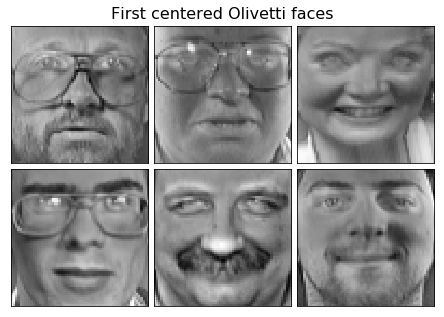

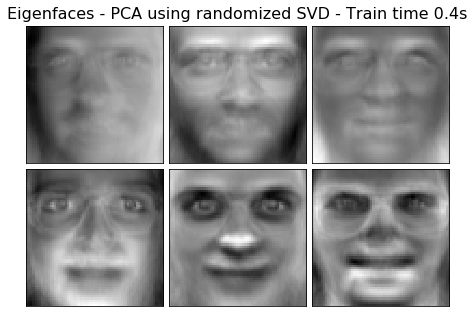

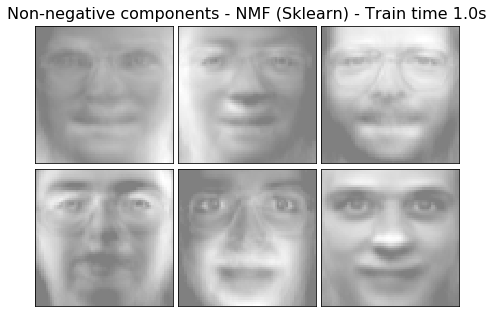

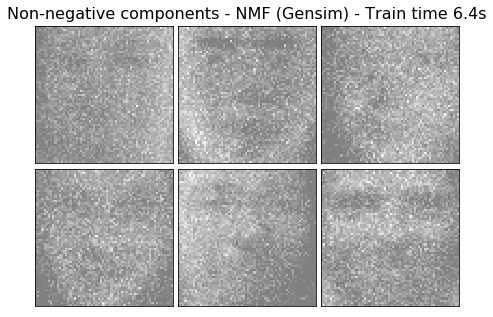

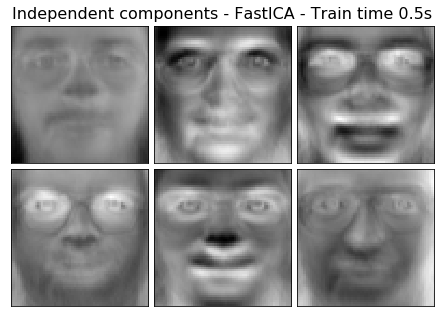

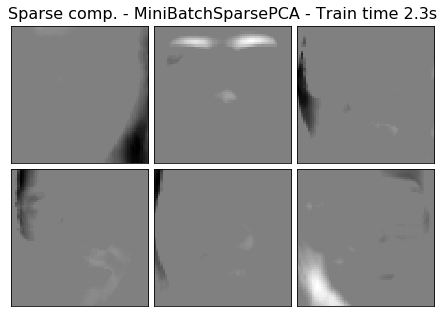

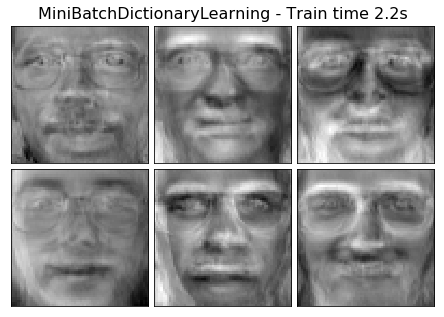

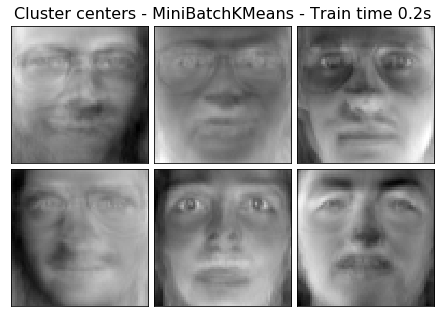

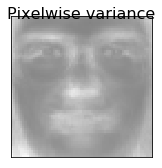

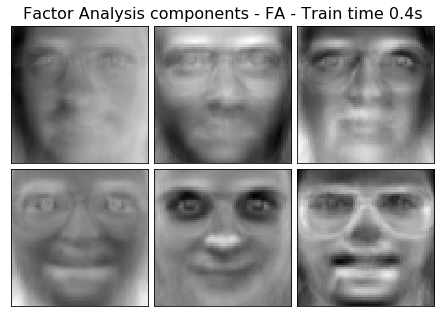

In [32]:
"""
============================
Faces dataset decompositions
============================

This example applies to :ref:`olivetti_faces` different unsupervised
matrix decomposition (dimension reduction) methods from the module
:py:mod:`sklearn.decomposition` (see the documentation chapter
:ref:`decompositions`) .

"""
print(__doc__)

# Authors: Vlad Niculae, Alexandre Gramfort
# License: BSD 3 clause

import logging
from time import time

from numpy.random import RandomState
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)

# #############################################################################
# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)


# #############################################################################
# List of the different estimators, whether to center and transpose the
# problem, and whether the transformer uses the clustering API.
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF (Sklearn)',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Non-negative components - NMF (Gensim)',
     NmfWrapper(
         chunksize=50,
         eval_every=1000,
         passes=5,
         sparse_coef=0,
         id2word={idx: idx for idx in range(faces.shape[1])},
         num_topics=n_components,
         minimum_probability=0
     ),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
     decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                               n_iter=50, batch_size=3,
                                               random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
     MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                     max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]

# #############################################################################
# Plot a sample of the input data

plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

# #############################################################################
# Do the estimation and plot it

for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_

    # Plot an image representing the pixelwise variance provided by the
    # estimator e.g its noise_variance_ attribute. The Eigenfaces estimator,
    # via the PCA decomposition, also provides a scalar noise_variance_
    # (the mean of pixelwise variance) that cannot be displayed as an image
    # so we skip it.
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.ndim > 0):  # Skip the Eigenfaces case
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()